In [3]:
conda install -c conda-forge lightgbm -y


2 channel Terms of Service accepted
Retrieving notices: done
Channels:
 - conda-forge
 - defaults
Platform: osx-arm64
Solving environment: done


==> WARNING: A newer version of conda exists. <==
    current version: 25.11.0
    latest version: 25.11.1

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /opt/miniconda3

  added / updated specs:
    - lightgbm


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-25.11.1              |  py313h8f79df9_0         1.2 MB  conda-forge
    khronos-opencl-icd-loader-2024.10.24|       h5505292_1          34 KB  conda-forge
    libboost-1.88.0            |       hb389264_0         2.2 MB
    liblightgbm-4.6.0          |   cpu_h7c95766_6         1.3 MB  conda-forge
    lightgbm-4.6.0             |         cpu_py_6          86 KB  conda-forge
    opencl-headers-2025.06.13  | 

In [22]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score

import lightgbm as lgb

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

train_df = pd.read_csv('../data/train.csv', sep=',')
test_df = pd.read_csv('../data/test.csv', sep=',')


In [7]:
print(train_df.shape)
train_df.head()

(700000, 26)


,id,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,...,gender,ethnicity,education_level,income_level,smoking_status,employment_status,family_history_diabetes,hypertension_history,cardiovascular_history,diagnosed_diabetes
0,0,31,1,45,7.7,6.8,6.1,33.4,0.93,112,...,Female,Hispanic,Highschool,Lower-Middle,Current,Employed,0,0,0,1.0
1,1,50,2,73,5.7,6.5,5.8,23.8,0.83,120,...,Female,White,Highschool,Upper-Middle,Never,Employed,0,0,0,1.0
2,2,32,3,158,8.5,7.4,9.1,24.1,0.83,95,...,Male,Hispanic,Highschool,Lower-Middle,Never,Retired,0,0,0,0.0
3,3,54,3,77,4.6,7.0,9.2,26.6,0.83,121,...,Female,White,Highschool,Lower-Middle,Current,Employed,0,1,0,1.0
4,4,54,1,55,5.7,6.2,5.1,28.8,0.90,108,...,Male,White,Highschool,Upper-Middle,Never,Retired,0,1,0,1.0


In [8]:
X = train_df.drop(columns=["diagnosed_diabetes", "id"])
y = train_df["diagnosed_diabetes"]

In [9]:
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numerical_cols   = X.select_dtypes(exclude=["object"]).columns.tolist()

print("Categorical:", categorical_cols)
print("Numerical:", numerical_cols)


Categorical: ['gender', 'ethnicity', 'education_level', 'income_level', 'smoking_status', 'employment_status']
Numerical: ['age', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', 'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'bmi', 'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides', 'family_history_diabetes', 'hypertension_history', 'cardiovascular_history']


In [10]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols),
        ("num", "passthrough", numerical_cols)
    ]
)


In [11]:
lgb_model = lgb.LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary",
    random_state=42,
    n_jobs=-1
)


In [12]:
pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", lgb_model)
    ]
)


In [13]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [14]:
pipeline.fit(X_train, y_train)


[LightGBM] [Info] Number of positive: 349046, number of negative: 210954
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012609 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1672
[LightGBM] [Info] Number of data points in the train set: 560000, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.623296 -> initscore=0.503564
[LightGBM] [Info] Start training from score 0.503564


,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Validation ROC-AUC: 0.72488


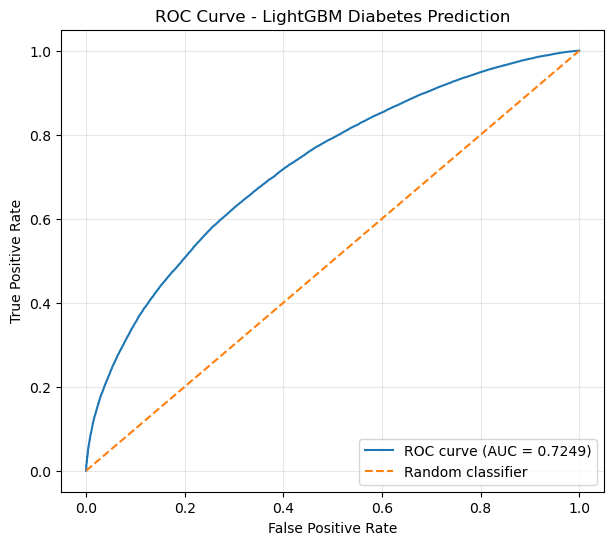

In [20]:
y_val_pred = pipeline.predict_proba(X_val)[:, 1]
roc_auc = roc_auc_score(y_val, y_val_pred)

print(f"Validation ROC-AUC: {roc_auc:.5f}")

# Calcular curva ROC
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - LightGBM Diabetes Prediction")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


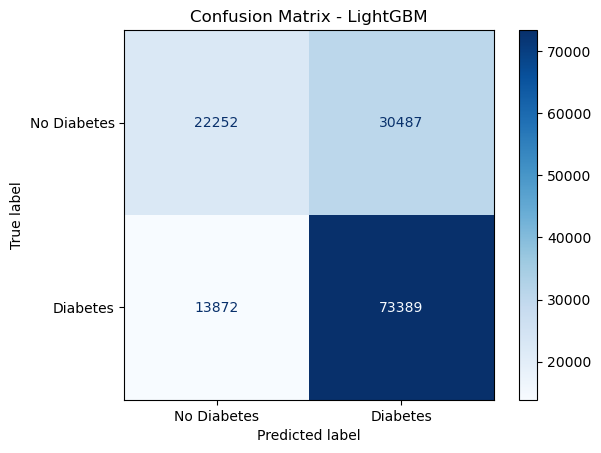

In [23]:
# Threshold (ajustable)
threshold = 0.5

# Probabilidades → clases
y_val_pred_prob = pipeline.predict_proba(X_val)[:, 1]
y_val_pred = (y_val_pred_prob >= threshold).astype(int)

# Calcular matriz
cm = confusion_matrix(y_val, y_val_pred)

# Plot con ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["No Diabetes", "Diabetes"]
)

disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - LightGBM")
plt.show()


In [16]:
# Obtener nombres de features tras el encoding
ohe = pipeline.named_steps["preprocessor"].named_transformers_["cat"]
ohe_features = ohe.get_feature_names_out(categorical_cols)

feature_names = np.concatenate([ohe_features, numerical_cols])

importances = pipeline.named_steps["model"].feature_importances_

feat_imp = (
    pd.DataFrame({"feature": feature_names, "importance": importances})
    .sort_values(by="importance", ascending=False)
)

feat_imp.head(15)


,feature,importance
26,physical_activity_minutes_per_week,3563
38,triglycerides,1572
24,age,1084
30,bmi,1043
35,cholesterol_total,914
37,ldl_cholesterol,868
34,heart_rate,712
32,systolic_bp,698
27,diet_score,662
36,hdl_cholesterol,625
